#  WGU MSDA D213 Advanced Analytics Task 1 - Time Series Modeling

## Jan Francis Mitchell Barlaan

### A1: Research Question
* My research question guiding this time series analysis is the following: "Can we predict revenue trends for subsequent months and are some months historically more profitable than others?"

### A2: Objectives or Goals
* The goal of this analysis is to forecast revenue for future months and observe if there are fluctuations. It can be useful to see if certain months incur more revenue than others and if the differences may be due to customer churn. 


### B: Summary of Assumptions
* Key assumptions of time series analysis are the following:


* Stationarity: this assumes that the series has a constant mean and variance over time.

* Uncorrelated Random Error: Error terms are expected to be uncorrelated, with constant mean and variance.

* Lack of Outliers: The presence of outliers can significantly skew analysis and are assumed to be absent or minimal.

* Random Shocks: Any shocks to the system are presumed to be random, with a mean of zero and constant variance (Kuo, What is time series analysis? 2024).

### C: Data Preparation
* Prior to analysis, the data set needs to be cleaned and prepared. I will use general code similar to ones used in my previous PA submissions to screen for duplicates, nulls, and outliers

In [1]:
# Import necessary initial packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(r'C:\Users\neoka\OneDrive\Desktop\WGU MSDA Course Material\D213\Churn Clean\teleco_time_series .csv')

df.head()

,Day,Revenue
0,1,0.000000
1,2,0.000793
2,3,0.825542
3,4,0.320332
4,5,1.082554


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Day      731 non-null    int64  
 1   Revenue  731 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 11.5 KB


In [4]:
#Check for duplicates

df.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
726    False
727    False
728    False
729    False
730    False
Length: 731, dtype: bool

In [5]:
#Show number of duplicates. False = no duplicates 

print(df.duplicated().value_counts())

False    731
dtype: int64


In [6]:
#Count of null/missing values in each column

df.isnull().sum()

Day        0
Revenue    0
dtype: int64

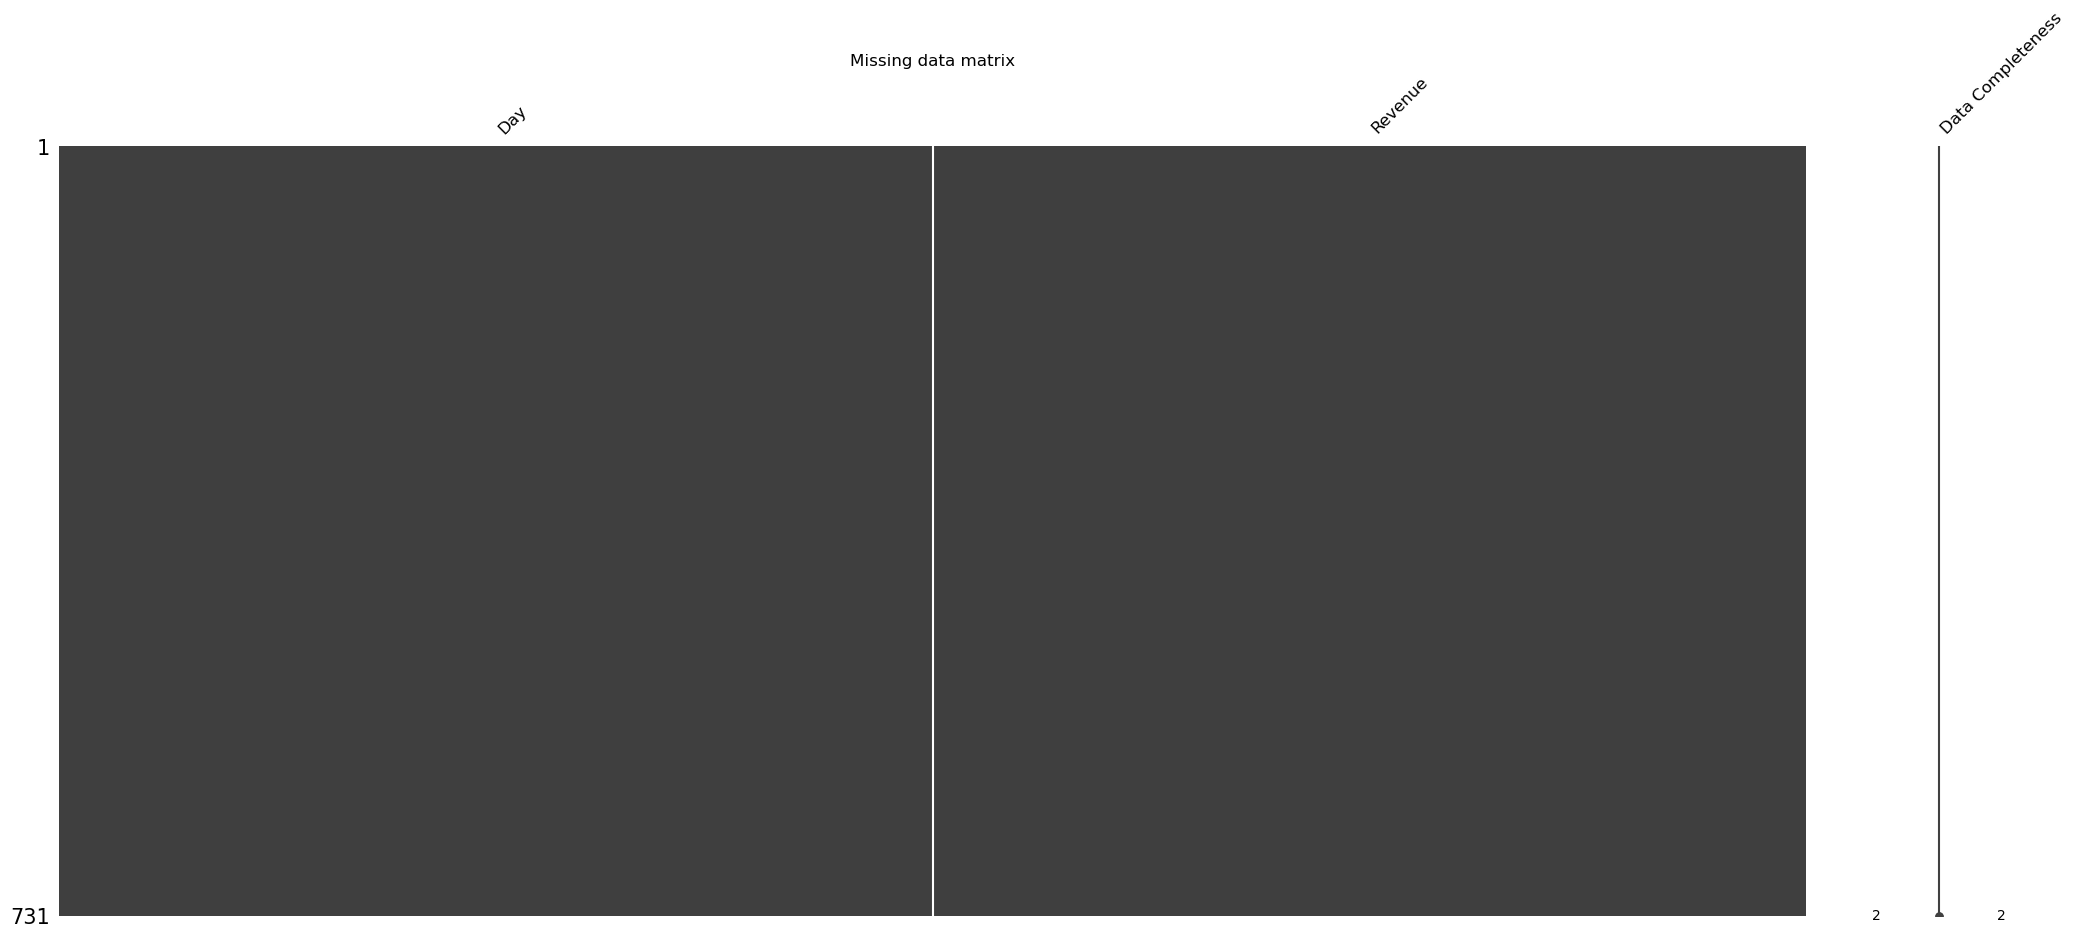

In [7]:
#Import missingno to visualize missing/null values 

import missingno as msno
msno.matrix(df, fontsize=12, labels=True)
plt.title('Missing data matrix')
plt.show()


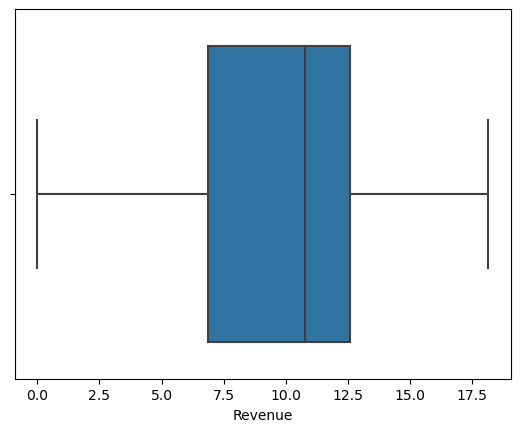

In [8]:
#Outlier check with boxplot on 'Revenue'

boxplot=sns.boxplot(x='Revenue',data=df)

In [9]:
# No Nulls, Outliers, or Duplicates were detected

### C1: Line Graph Visualization

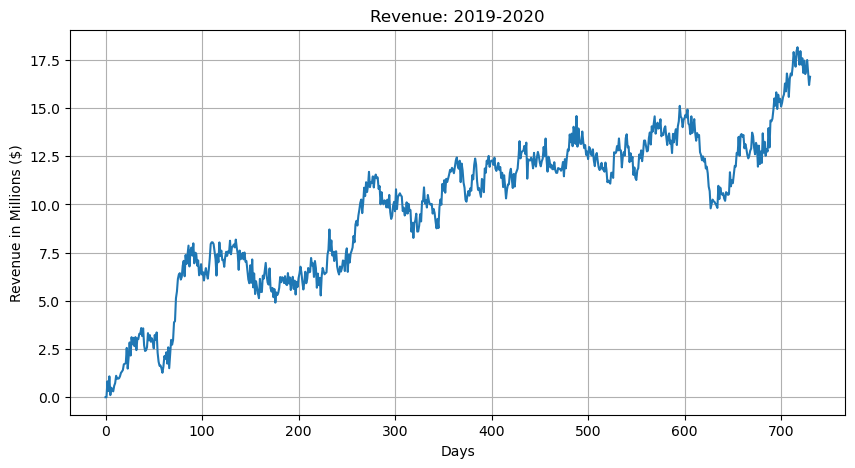

In [10]:
# Visualize the realization of time series
plt.figure(figsize=(10,5))
df['Revenue'].plot(title='Revenue: 2019-2020')
plt.xlabel("Days")
plt.ylabel("Revenue in Millions ($)")
plt.grid(True)
plt.show()

### C2: Time Step Formatting
* There are no gaps in measurement as evidenced by our line graph and also due to the lack of nulls present. The current datetime index is represented in single day increments per observation, ranging from January 1st, 2019 to December 31st, 2020. There are 731 observations during the duration of these two years, implying that one year was a leap year (365 + 366 = 731). 2020 fits this criteria and was indeed a leap year with 366 days. 


* We will reformat the data as a DateTime object in order to give us the ability to manipulate the data and aggregate in increments of week, month, year, etc). 

In [11]:
# Code similar to Dr. Elleh's webinars

# Convert Day to a DateTime format, specifying 2019-01-01 as the start date
from datetime import datetime
df['Day'] = (pd.date_range(start=datetime(2019,1,1), periods=df.shape[0], freq='D'))
df.head()

,Day,Revenue
0,2019-01-01,0.000000
1,2019-01-02,0.000793
2,2019-01-03,0.825542
3,2019-01-04,0.320332
4,2019-01-05,1.082554


In [12]:
# Set Day as index
df.set_index('Day', inplace=True)
df.head()

,Revenue
Day,
2019-01-01,0.000000
2019-01-02,0.000793
2019-01-03,0.825542
2019-01-04,0.320332
2019-01-05,1.082554


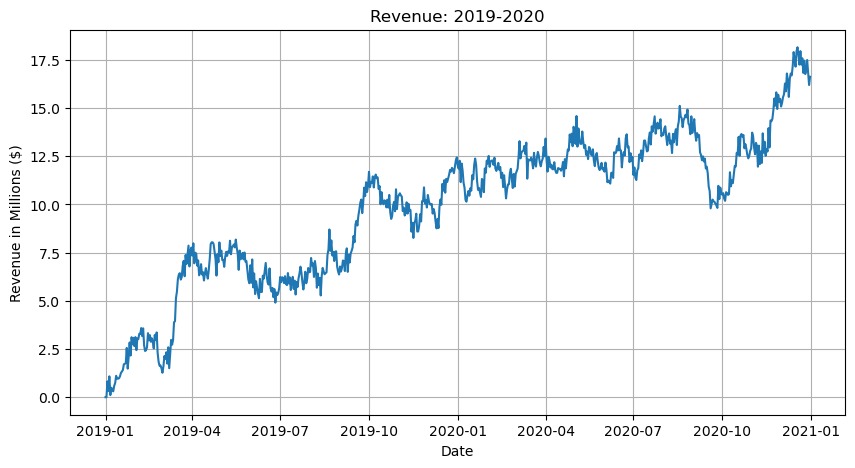

In [13]:
#Plot Line Graph again after Day conversion to DateTime format

plt.figure(figsize=(10,5))
plt.plot(df.Revenue)

plt.title('Revenue: 2019-2020')
plt.xlabel('Date')
plt.ylabel('Revenue in Millions ($)')
plt.grid(True)
plt.show()

### C3: Stationarity
* Upon initial visual inspection of the line graph, we can already tell that our data is not stationary due to the increasing/upward trend. To further support this observation, we will conduct the Augmented Dickey-Fuller (ADF) test to provide a formal evaluation of the data's stationarity (Bobbitt, 2021). 

* The ADF test performs a hypothesis test using the following null and alternative hypotheses for its criteria
* Null hypothesis = non-stationary time series
* Alternative hypothesis = stationary time series

* The adfuller() function is used and a p-value is evaluated in determining which hypothesis to accept/reject. For our purposes, we will use a p-value = 0.05. Therefore, if the resulting p-value < 0.05, then we reject the null hypothesis and pick the alternative hypothesis and vice versa.

In [14]:
# ADF test 
# Code similar to Dr. Elleh's webinars

# ADF test 
# (Elleh, n.d.)

from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Revenue'])
print("Test statistics: ", result[0])
print("p-value: ", result[1])
print("Critical values: ", result[4])

Test statistics:  -1.9246121573101858
p-value:  0.3205728150793956
Critical values:  {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}


In [15]:
# Null hypothesis = time series is non-stationary 
# Alternative hypothesis = time series is stationary

if result[1] <= 0.05: 
    print("Reject null hypothesis. The time series is stationary")
else: 
    print("Fail to reject null hypothesis. The time series is non-stationary")

Fail to reject null hypothesis. The time series is non-stationary


* As we can see in the ADF test performed above, our p-value  of 0.32 > 0.05. Our time series is non-stationary 

* Next, we need to difference the data in order to convert it to stationary. We accomplish this by using the diff() function to take the difference of each successive datapoint. An empty entry on the first date will be created since there is no preceding date to take a difference from. We will need to omit this point from the transformed data by using the dropna() function (Jones, Transforming non-stationary time series with differencing 2025). Our final data series will be reduced from 731 to 730 data points (GeeksforGeeks, How to remove non-stationarity in time series forecasting 2024).

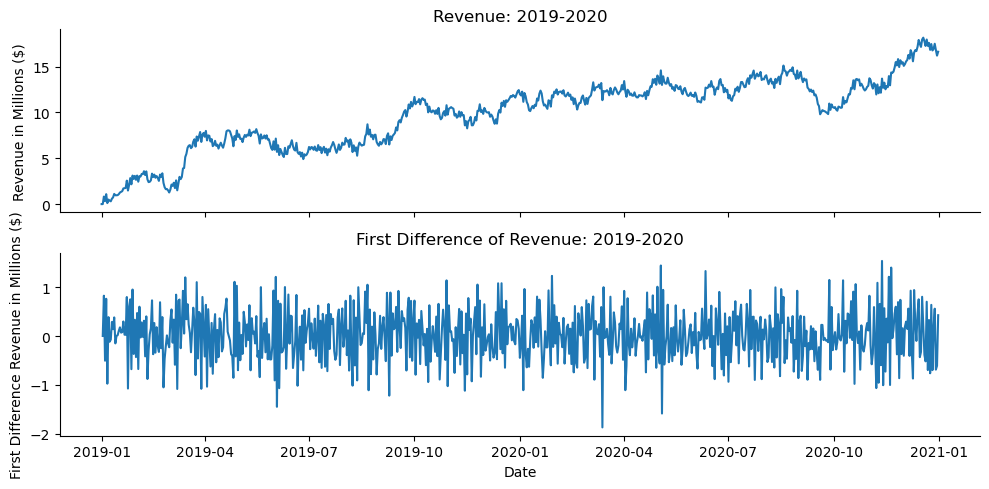

In [16]:
# Difference the data to make it stationary:


# First differencing
df['First Difference'] = df['Revenue'].diff().dropna()


# Create figure and subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)


#Plot of time series prior to differencing

axes[0].plot(df['Revenue'])
axes[0].set_title('Revenue: 2019-2020', fontsize=12)
axes[0].set_ylabel('Revenue in Millions ($)', fontsize=10)

#Plot of time series after differencing once

axes[1].plot(df['First Difference'])
axes[1].set_title('First Difference of Revenue: 2019-2020', fontsize=12)
axes[1].set_xlabel ('Date')
axes[1].set_ylabel('First Difference Revenue in Millions ($)', fontsize=10)

for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(False)

plt.tight_layout()
plt.show()



In [17]:
#Run ADF test a second time to confirm that the data is now stationary

result = adfuller(df['Revenue'].diff().dropna())
print("Test statistics: ", result[0])
print("p-value: ", result[1])
print("Critical values: ", result[4])

Test statistics:  -44.87452719387599
p-value:  0.0
Critical values:  {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}


In [18]:
# Null hypothesis = time series is non-stationary 
# Alternative hypothesis = time series is stationary

if result[1] <= 0.05: 
    print("Reject null hypothesis. The time series is stationary")
else: 
    print("Fail to reject null hypothesis. The time series is non-stationary")

Reject null hypothesis. The time series is stationary


* After differencing once, the time series is now stationary

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2019-01-01 to 2020-12-31
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Revenue           731 non-null    float64
 1   First Difference  730 non-null    float64
dtypes: float64(2)
memory usage: 17.1 KB


In [20]:
df.head()

,Revenue,First Difference
Day,,
2019-01-01,0.000000,NaN
2019-01-02,0.000793,0.000793
2019-01-03,0.825542,0.824749
2019-01-04,0.320332,-0.505210
2019-01-05,1.082554,0.762222


In [21]:
df = df['Revenue'].diff().dropna()

In [22]:
df.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 730 entries, 2019-01-02 to 2020-12-31
Series name: Revenue
Non-Null Count  Dtype  
--------------  -----  
730 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB


In [23]:
df.head()

Day
2019-01-02    0.000793
2019-01-03    0.824749
2019-01-04   -0.505210
2019-01-05    0.762222
2019-01-06   -0.974900
Name: Revenue, dtype: float64

In [24]:
Cleaned_Time_Series_df = df

### C4: Steps to Prepare the Data

* The necessary libraries and packages were imported along with the provided starting dataset.

* Data exploration was performed with the info() and head() functions.

* Data cleaning was done by screening for nulls, duplicates, and outliers. None of any were found, so no further cleaning was performed.

* The 'Revenue' column was visualized via line graph plot to provide insight into any possible trends

* The 'Day' column was converted from integer to DateTime format and set as the index for the dataframe so that it could be used properly in the time series analysis

* Following the 'Day' column conversion, the 'Revenue' column was plotted again via line graph 

* Stationarity was tested and the dataset was found to be non-stationary. This was addressed with one round of differencing to convert it to stationary.

* This step technically happens after our last step outlined in this section, but Section D2 will provide the code and further details of this step. The auto_arima package and its functions will be used to find the optimal ARIMA model and matching parameters for our dataset.

* The differenced dataset is saved into a new csv file as shown below in section C5 under the name 'Cleaned_Time_Series_df.csv'.

* Next, the differenced dataset is split into a 80:20 train:test split as observed at the end of section C5. These are then saved into their own csv files. The train set is saved under 'Time_Series_train.csv' and the test set is saved under 'Time_Series_test.csv'.

### C5: Prepared Data Set

In [25]:
#Export cleaned dataframe to csv
Cleaned_Time_Series_df.to_csv('Cleaned_Time_Series_df.csv', index=False)

In [26]:
# Split time series into a training set and a test set

from sklearn.model_selection import train_test_split

train, test = train_test_split(Cleaned_Time_Series_df, test_size=0.2, shuffle=False, random_state=42)

train

Day
2019-01-02    0.000793
2019-01-03    0.824749
2019-01-04   -0.505210
2019-01-05    0.762222
2019-01-06   -0.974900
                ...   
2020-08-03    0.113264
2020-08-04   -0.531705
2020-08-05   -0.437835
2020-08-06    0.422243
2020-08-07    0.179940
Name: Revenue, Length: 584, dtype: float64

In [27]:
test

Day
2020-08-08   -0.531923
2020-08-09    0.157387
2020-08-10   -0.644689
2020-08-11    0.995057
2020-08-12   -0.438775
                ...   
2020-12-27    0.170280
2020-12-28    0.559108
2020-12-29   -0.687028
2020-12-30   -0.608824
2020-12-31    0.425985
Name: Revenue, Length: 146, dtype: float64

In [28]:
Time_Series_train = train

Time_Series_test = test

In [29]:
#Export Time Series train and test sets to csv
Time_Series_train.to_csv('Time_Series_train.csv', index=False)

Time_Series_test.to_csv('Time_Series_test.csv', index=False)

### D1: Report Findings and Visualizations


* #### D1a: The presence or lack of a seasonal component

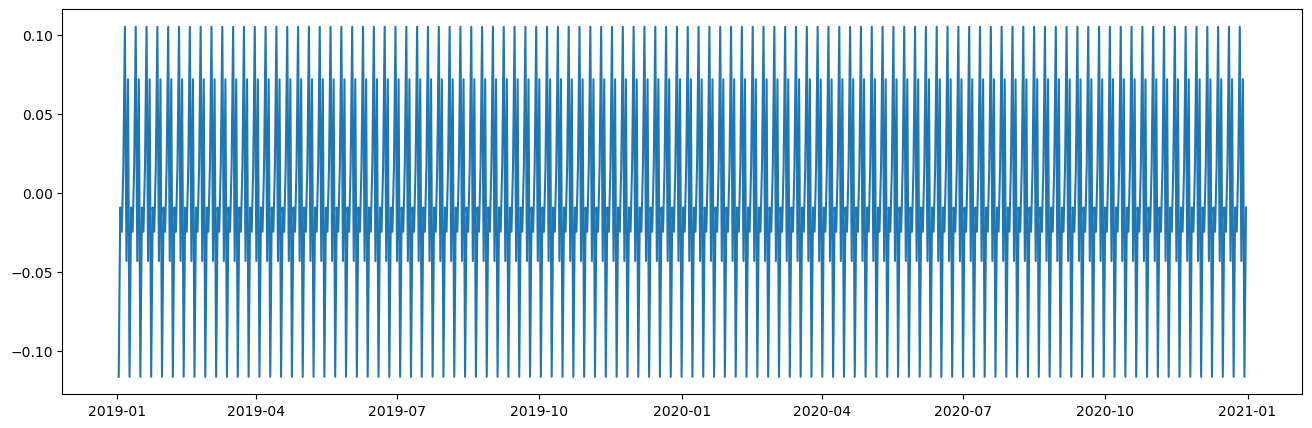

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose


# Decompose the transformed data
decomposed_data = seasonal_decompose(Cleaned_Time_Series_df)

#Set plot size
plt.figure(figsize = [16,5])

# Plot seasonal component of the data
plt.plot(decomposed_data.seasonal)
plt.show()

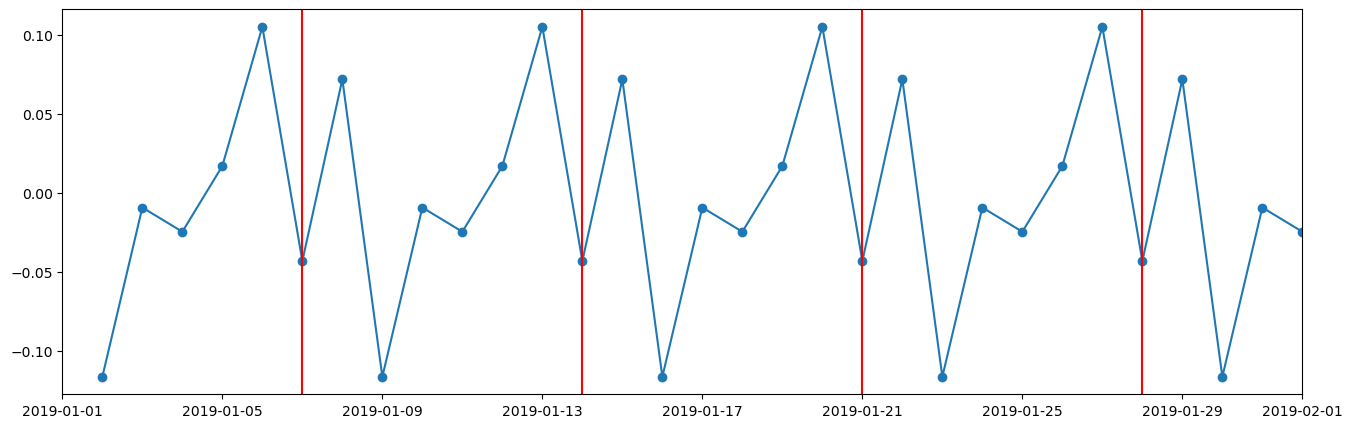

In [31]:
#Set plot size
plt.figure(figsize = [16,5])

# Plot seasonal component of the data
plt.plot(decomposed_data.seasonal, marker='o')
plt.xlim(pd.to_datetime('2019-01-01'), pd.to_datetime('2019-02-01'))

# Draw red lines on Mondays
plt.axvline(x=pd.to_datetime('2019-01-07'), color='red')
plt.axvline(x=pd.to_datetime('2019-01-14'), color='red')
plt.axvline(x=pd.to_datetime('2019-01-21'), color='red')
plt.axvline(x=pd.to_datetime('2019-01-28'), color='red')

plt.show()


* Upon decomposing the data and observing for a seasonal component, we can see that there are clear repeating patterns that occur several times within a period of months. Therefore, we can conclude that seasonality is present (Nicolini, Time Series Forecasting: A practical guide to exploratory data analysis 2025).
* Additionally, since seasonality is present, a SARIMAX model may be the best one to use for our dataset. We will confirm this later with auto_arima.

* #### D1b:  Trends

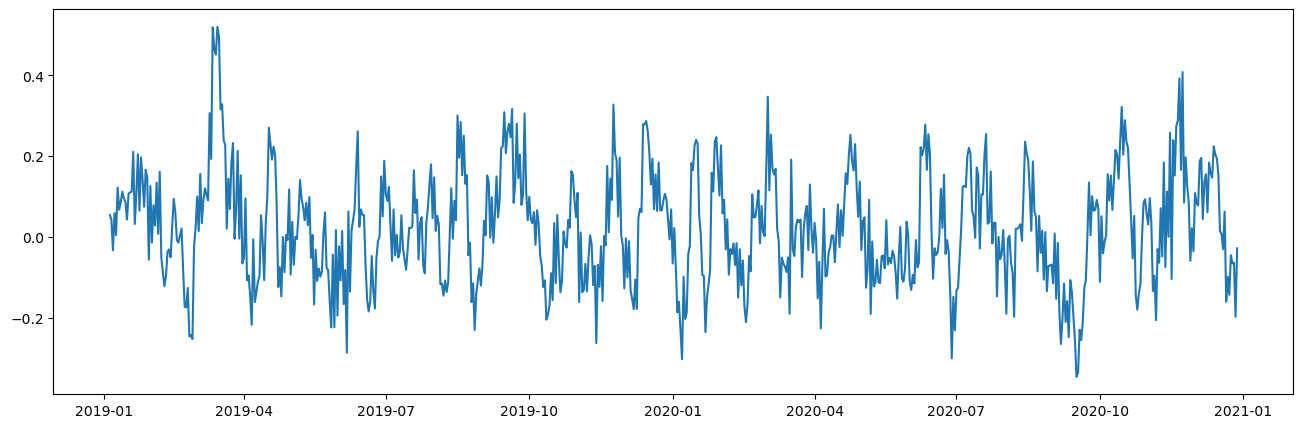

In [32]:
#Set plot size
plt.figure(figsize = [16,5])

# Plot trend component of the data
plt.plot(decomposed_data.trend)

plt.show()

* There is no obvious trend seen in this particular graph, but possibly an outlier may exist around Spring 2019/March-April 2019.

* ####  D1c: The autocorrelation function

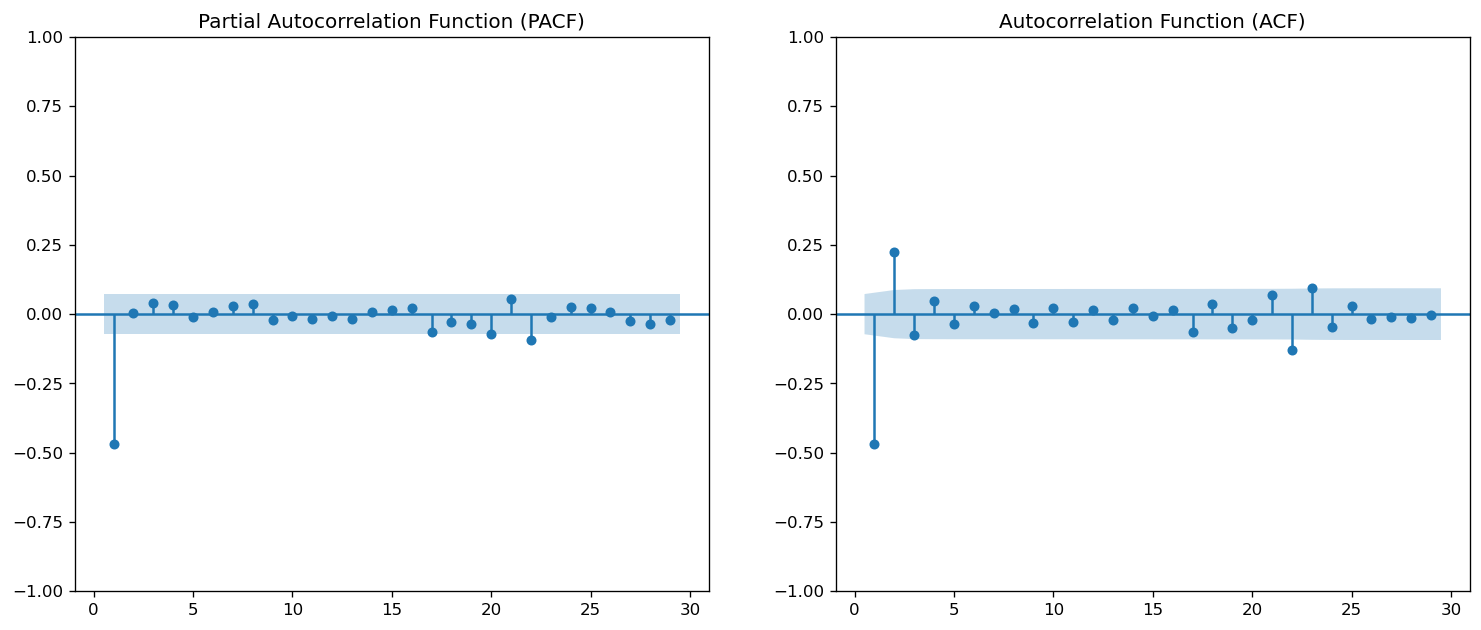

In [33]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.rcParams.update({'figure.figsize': (15, 6), 'figure.dpi': 120})

fig, axes = plt.subplots(1, 2)

plot_pacf(Cleaned_Time_Series_df, ax=axes[0], zero=False)
axes[0].set_title('Partial Autocorrelation Function (PACF)')

plot_acf(Cleaned_Time_Series_df, ax=axes[1], zero=False)
axes[1].set_title('Autocorrelation Function (ACF)')

plt.show()

* #### D1d: The spectral density

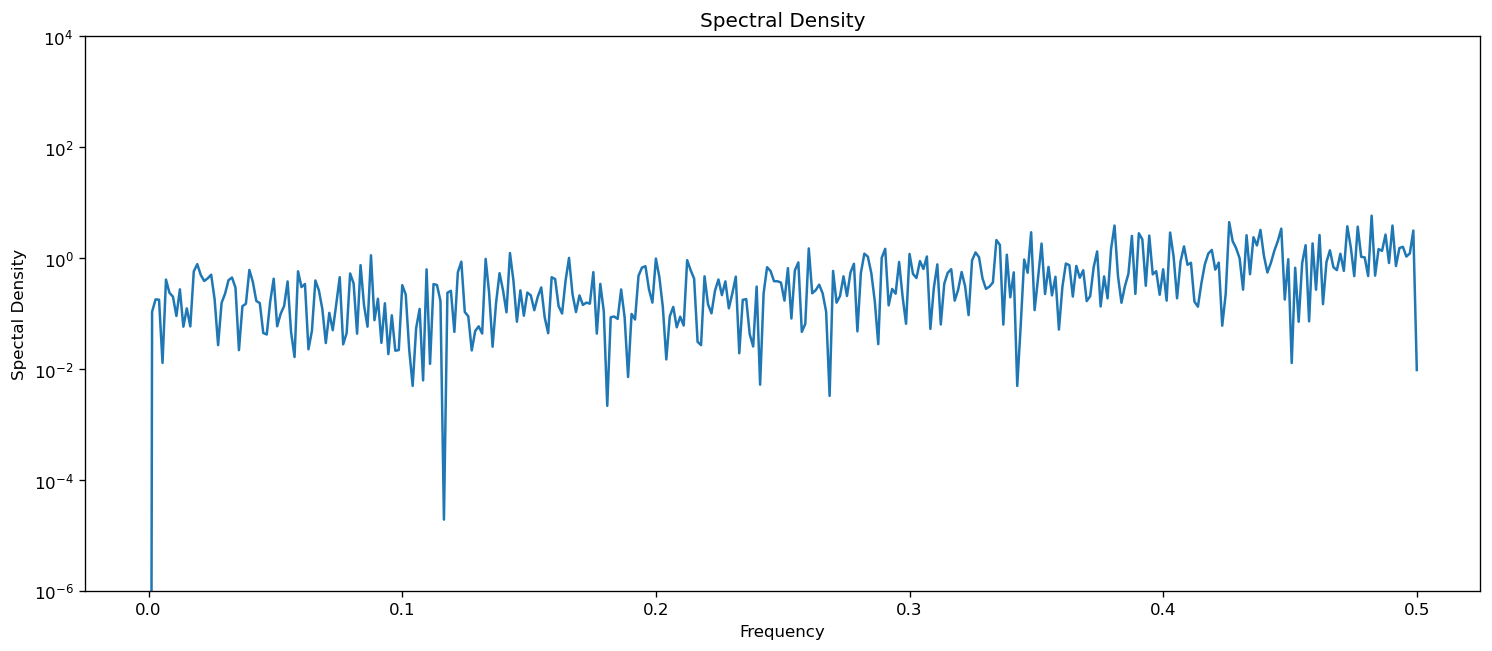

In [34]:
# Power spectral density
from scipy import signal
f, Pxx_den = signal.periodogram(Cleaned_Time_Series_df)
plt.semilogy(f, Pxx_den)
plt.ylim([1e-6, 1e4])
plt.title('Spectral Density')
plt.xlabel('Frequency')
plt.ylabel('Spectal Density')
plt.show()

* ACF, PACF, and Spectral Density are shown for good meausure, but ultimately, we will defer to auto_arima to determine the best model for our data.

* #### D1e: The decomposed time series

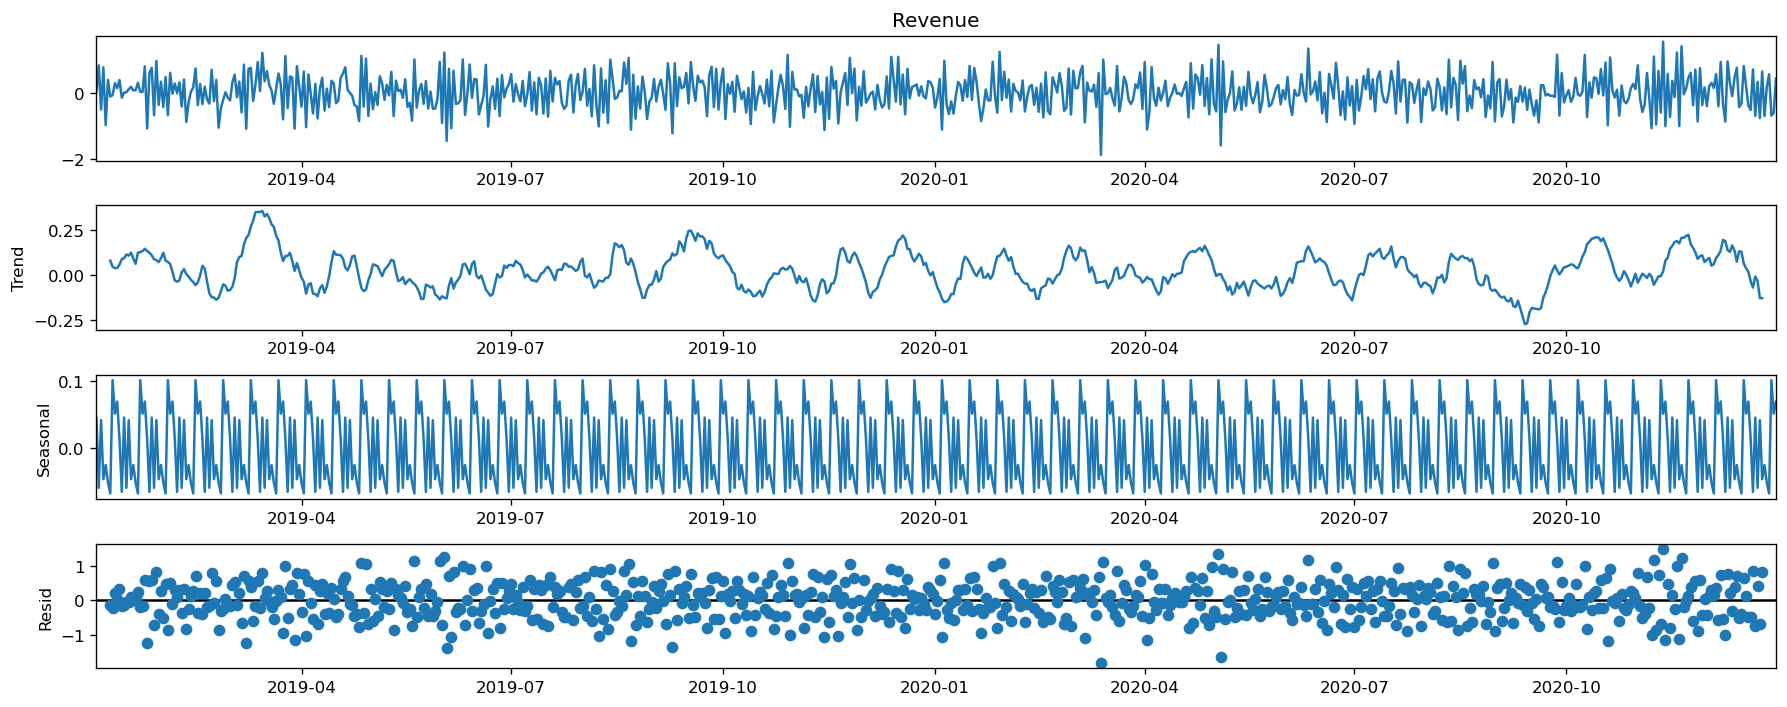

In [35]:
result = seasonal_decompose((Cleaned_Time_Series_df), model='additive', period=12)

# Plot Trend, Seasonality, Residuals
result.plot()
plt.show()

* #### D1f: Confirmation of the lack of trends in the residuals of the decomposed series

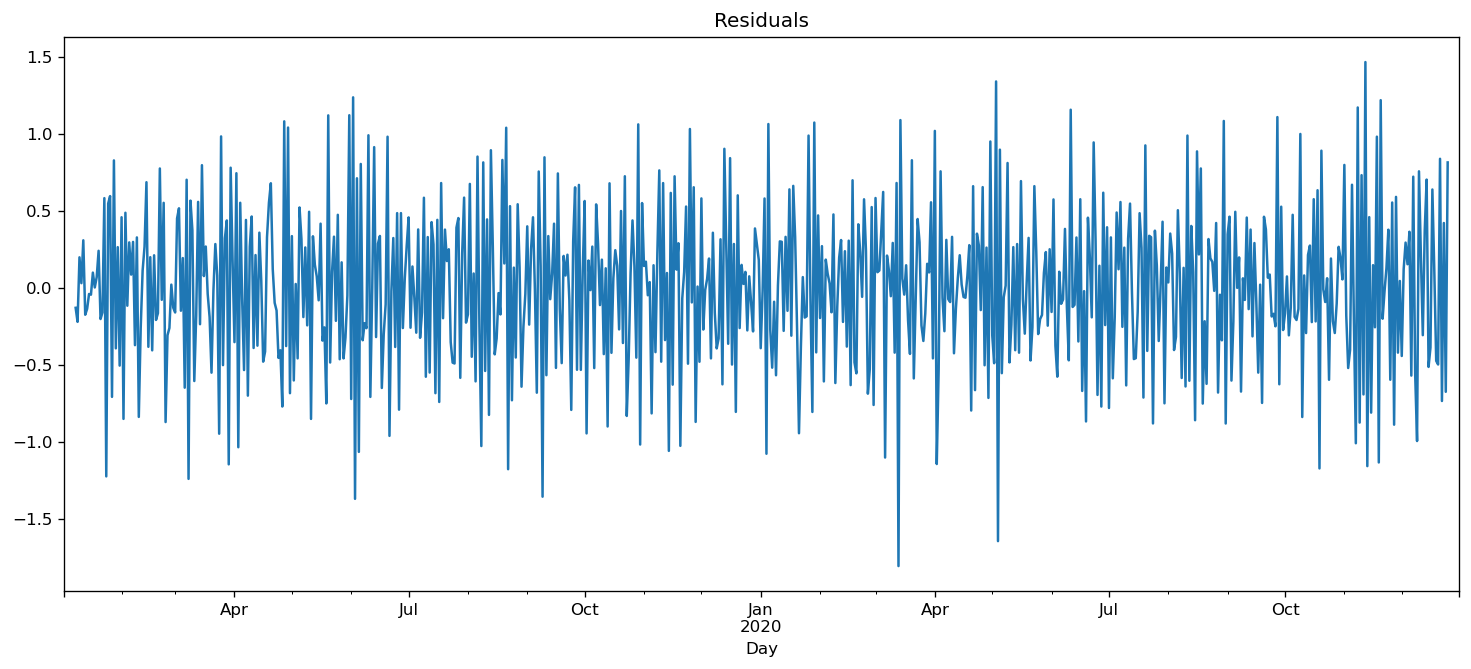

In [36]:
plt.rcParams.update({'figure.figsize': (15, 6), 'figure.dpi': 120})

plt.title("Residuals")
result.resid.plot()
plt.show()

* Subjectively, there are no obvious trends in the plotted residuals of decomposition.

### D2: Arima Model


* As discussed several times previously, we will use auto_arima to find the best ARIMA model. ARIMA is used for non-seasonal trends, SARIMA models account for seasonality, and SARIMAX is an extension of SARIMA by accounting for both seasonality and exogenous variables (Resende, Arima, Sarima, and SARIMAX explained 2024).

In [37]:
# Fit the auto_arima function to the differenced dataset

from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error


# import and ignore warnings

import warnings
warnings.filterwarnings('ignore')


stepwise_fit = auto_arima(Cleaned_Time_Series_df, start_p=1, start_q=1, max_p = 3, max_q = 3, m = 12, 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  
                          stepwise = True)           
  
# To print the summary 
stepwise_fit.summary() 

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.54 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1630.978, Time=0.15 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1267.745, Time=0.71 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.09 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1628.989, Time=0.06 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1470.699, Time=0.14 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1154.433, Time=1.75 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.53 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.23 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1351.604, Time=1.94 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1156.264, Time=2.11 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=1156.304, Time=2.89 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=1202.537, Time=2.00 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=1153.406, Time=4.46 sec
 ARIMA(2,0,1)(1,1,0)[12] intercept   : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  730
Model:             SARIMAX(3, 0, 1)x(2, 1, [], 12)   Log Likelihood                -568.357
Date:                             Mon, 10 Mar 2025   AIC                           1150.713
Time:                                     12:47:16   BIC                           1182.749
Sample:                                 01-02-2019   HQIC                          1163.082
                                      - 12-31-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1468      0.225      0.651      0.515      -0.295       0.589
ar.L2          0.3659      0.108      3.394      0.001       0.155       0.577
ar.L3          0.0700      0.043      1.612      0.107      -0.015       0.155
ma.L1         -0.6431      0.226     -2.848      0.004      -1.086      -0.201
ar.S.L12      -0.7138      0.038    -18.795      0.000      -0.788      -0.639
ar.S.L24      -0.3943      0.038    -10.419      0.000      -0.468      -0.320
sigma2         0.2820      0.016     18.062      0.000       0.251       0.313
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.99
Prob(Q):                              0.97   Prob(JB):                         0.61
Heteroskedasticity (H):               1.08   Skew:                            -0.03
Prob(H) (two-sided):                  0.56   Kurtosis:                         2.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

* Based on our auto_arima results, a SARIMAX model is the best fit for our dataset. 

In [38]:
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error


# import and ignore warnings

import warnings
warnings.filterwarnings('ignore')


# The model identified by fitting the auto_arima function to df_diff is: SARIMAX(3, 0, 1)x(2, 1, [], 12)
# Note: the '[]' indicates no seasonal moving average included in the model, and this will be replaced with 1
# So the SARIMAX model going forward will be interpreted as: SARIMAX(3, 0, 1)x(2, 1, 1, 12)

# Fit the SARIMAX model on the training set
model = SARIMAX(Time_Series_train,  
                order = (3, 0, 1),  
                seasonal_order =(2, 1, 1, 12)) 
  
results = model.fit() 
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            Revenue   No. Observations:                  584
Model:             SARIMAX(3, 0, 1)x(2, 1, 1, 12)   Log Likelihood                -395.495
Date:                            Mon, 10 Mar 2025   AIC                            806.991
Time:                                    12:47:21   BIC                            841.784
Sample:                                01-02-2019   HQIC                           820.564
                                     - 08-07-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4135      0.715     -0.578      0.563      -1.816       0.989
ar.L2          0.0482      0.342      0.141      0.888      -0.622       0.719
ar.L3          0.0644      0.041      1.553      0.120      -0.017       0.146
ma.L1         -0.0608      0.718     -0.085      0.933      -1.469       1.347
ar.S.L12      -0.0616      0.049     -1.246      0.213      -0.159       0.035
ar.S.L24      -0.0130      0.048     -0.270      0.788      -0.108       0.082
ma.S.L12      -0.9520      0.029    -32.329      0.000      -1.010      -0.894
sigma2         0.2214      0.014     15.376      0.000       0.193       0.250
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 3.10
Prob(Q):                              0.94   Prob(JB):                         0.21
Heteroskedasticity (H):               0.98   Skew:                            -0.08
Prob(H) (two-sided):                  0.89   Kurtosis:                         2.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### D3: Forecasting Using Arima Model



* Our test dataset contains 146 observations, so we will try to make a prediction for those values and check it against actual values in the test dataset.

In [39]:
# Predictions of the model against the test set 
start = len(Time_Series_train)
end = len(Time_Series_train) + len(Time_Series_test) - 1

# This sets the range for the prediction to the test set, which covers 20% of the data set
print(start)
print(end)

584
729


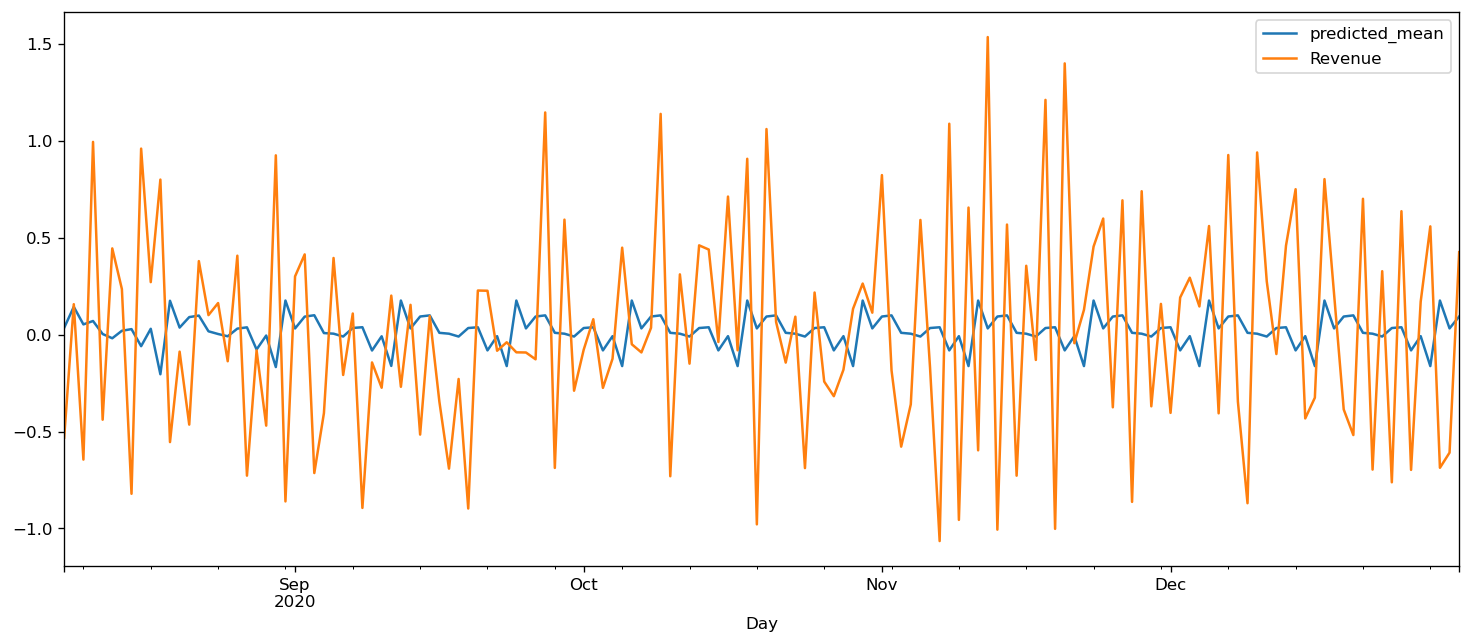

In [40]:
# Predictions for the 20% test set (146 days)
predictions = results.get_prediction(start, end, dynamic = True)

# Plot predictions against actual values

predictions.predicted_mean.plot(legend = True) 

Time_Series_test.plot(legend = True) 


plt.show()

In [41]:
#Reimport original starting dataset
df = pd.read_csv(r'C:\Users\neoka\OneDrive\Desktop\WGU MSDA Course Material\D213\Churn Clean\teleco_time_series .csv')

df.head()


,Day,Revenue
0,1,0.000000
1,2,0.000793
2,3,0.825542
3,4,0.320332
4,5,1.082554


In [42]:
#Re-establish conversion of Day to a DateTime format, specifying 2019-01-01 as the start date


# Code similar to Dr. Elleh's webinars

# Convert Day to a DateTime format, specifying 2019-01-01 as the start date
from datetime import datetime
df['Day'] = (pd.date_range(start=datetime(2019,1,1), periods=df.shape[0], freq='D'))
df.head()

,Day,Revenue
0,2019-01-01,0.000000
1,2019-01-02,0.000793
2,2019-01-03,0.825542
3,2019-01-04,0.320332
4,2019-01-05,1.082554


In [43]:
# Re-establish setting Day as an index
df.set_index('Day', inplace=True)
df.head()

,Revenue
Day,
2019-01-01,0.000000
2019-01-02,0.000793
2019-01-03,0.825542
2019-01-04,0.320332
2019-01-05,1.082554


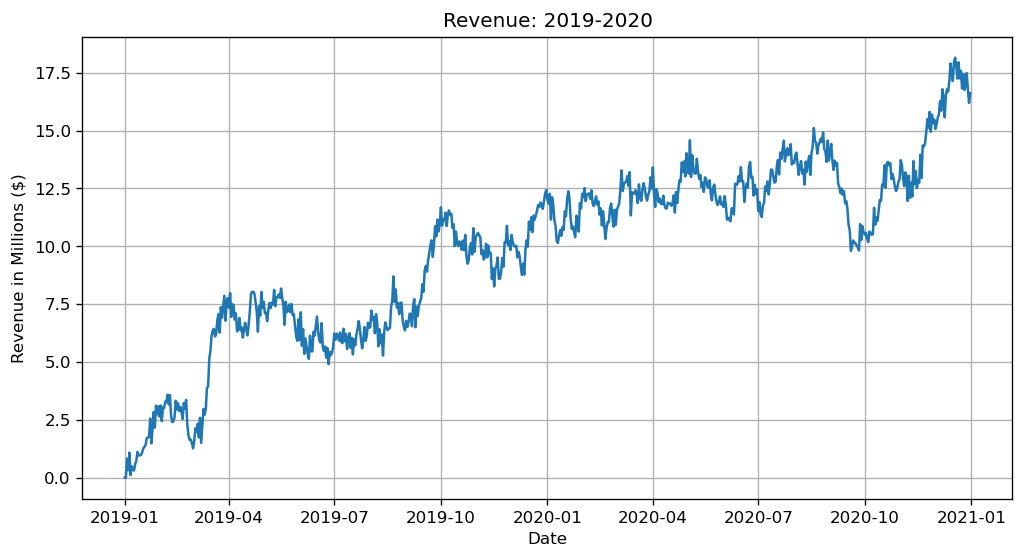

In [44]:
#Check for successful re-establishment of Day to a DateTime format and setting Day as an index


#Plot Line Graph again after Day conversion to DateTime format

plt.figure(figsize=(10,5))
plt.plot(df.Revenue)

plt.title('Revenue: 2019-2020')
plt.xlabel('Date')
plt.ylabel('Revenue in Millions ($)')
plt.grid(True)
plt.show()

In [45]:
# Train the model on the full dataset 
model = SARIMAX(df['Revenue'],  
                        order = (3, 0, 1),  
                        seasonal_order =(2, 1, 1, 12)) 
results = model.fit() 


In [46]:
# Forecast 146 steps ahead (146 days since 729 - 584 + 1 = 146 )

forecast_steps = 146 
forecast_result = results.get_forecast(steps=forecast_steps,  dynamic=True)

In [47]:
#Calculate confidence interval

confidence_intervals = forecast_result.conf_int()
    
confidence_intervals

,lower Revenue,upper Revenue
2021-01-01,15.611880,17.485127
2021-01-02,15.457150,17.574944
2021-01-03,15.262241,17.806509
2021-01-04,15.112411,17.926171
2021-01-05,15.012811,18.115100
...,...,...
2021-05-22,10.066909,26.820013
2021-05-23,10.063039,26.887541
2021-05-24,10.111961,27.007435
2021-05-25,10.148024,27.119809


In [48]:
forecast_result.predicted_mean

2021-01-01    16.548503
2021-01-02    16.516047
2021-01-03    16.534375
2021-01-04    16.519291
2021-01-05    16.563955
                ...    
2021-05-22    18.443461
2021-05-23    18.475290
2021-05-24    18.559698
2021-05-25    18.633917
2021-05-26    18.528230
Freq: D, Name: predicted_mean, Length: 146, dtype: float64

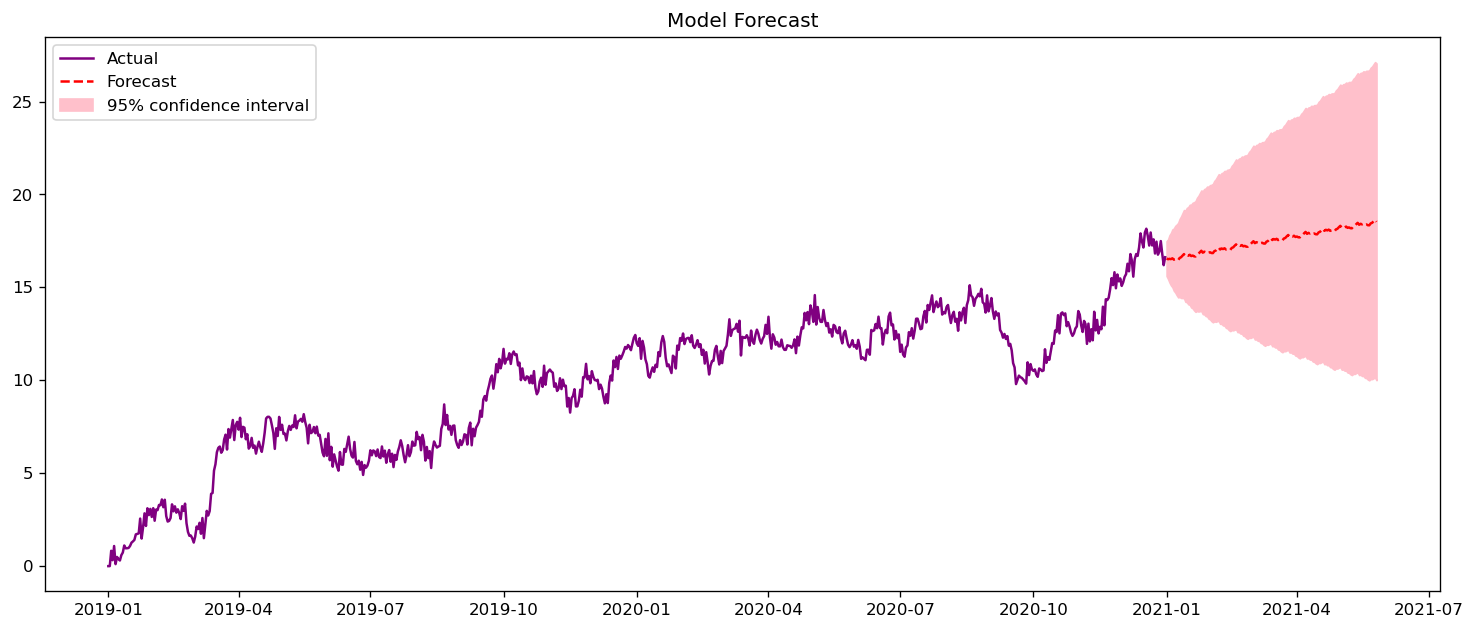

In [49]:
# Plot forecast and confidence intervals

plt.plot(df, color='purple', label='Actual')
plt.plot(forecast_result.predicted_mean, color='red', label='Forecast', linestyle='dashed')
plt.fill_between(confidence_intervals.index, confidence_intervals['lower Revenue'], confidence_intervals['upper Revenue'], color = 'pink', label='95% confidence interval')
plt.plot()
plt.legend(loc='upper left')
plt.title('Model Forecast')
plt.show()

In [50]:
# Print forecast summary and confidence intervals
print(results.summary())
print('\nForecast:')
print(forecast_result.predicted_mean)
print('\nConfidence Intervals:')
print(confidence_intervals)

                                     SARIMAX Results                                      
Dep. Variable:                            Revenue   No. Observations:                  731
Model:             SARIMAX(3, 0, 1)x(2, 1, 1, 12)   Log Likelihood                -505.374
Date:                            Mon, 10 Mar 2025   AIC                           1026.749
Time:                                    12:47:30   BIC                           1063.372
Sample:                                01-01-2019   HQIC                          1040.888
                                     - 12-31-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3241      1.095     -0.296      0.767      -2.471       1.823
ar.L2          0.9238      0.563   

In [51]:
#Calculate MSE and RMSE for additional model performance metrics

from sklearn.metrics import mean_squared_error 
from statsmodels.tools.eval_measures import rmse 

#First, we need to extract values from our dataframe
actual_values = df['Revenue'].iloc[-146:].values 


#Next, we need to extract our forecasted values
forecasted_values = forecast_result.predicted_mean.values

#MSE Calculation
print('MSE=', round(mean_squared_error(actual_values, forecasted_values), 3))

#RMSE Calculation
print('RMSE=', round(rmse(actual_values, forecasted_values), 3))

MSE= 18.595
RMSE= 4.312


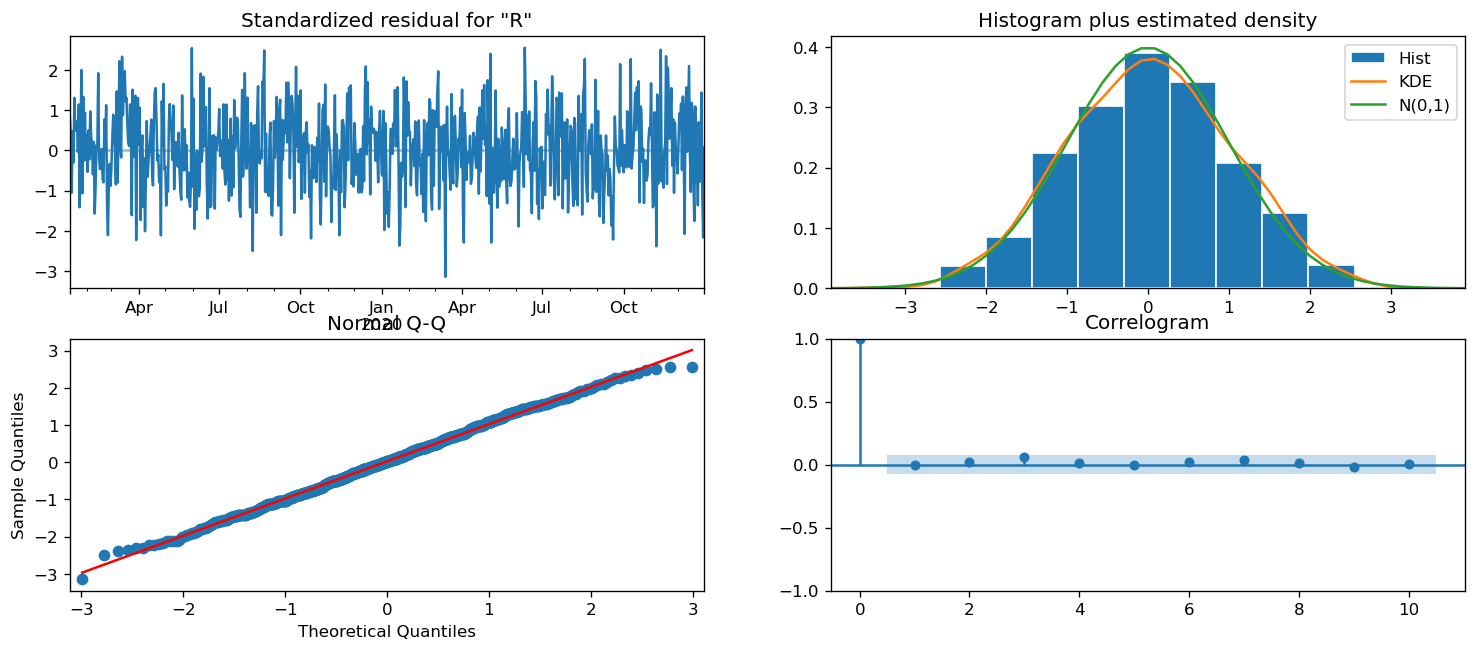

In [52]:
#Diagnostic plots for model performance

results.plot_diagnostics(figsize=(15,6))
plt.show()

### D4: Output and Calculations
* All calculations performed, including their resulting outputs, can be seen above.

### D5: Code
* All of my code used in the implementation of this time series analysis is present throughout the entire report.

### E1: Results

* E1a: The selection of an ARIMA model
* Our SARIMAX model was selected via the auto_arima function with optimal model parameters set at the following: SARIMAX(3, 0, 1)x(2, 1, 1, 12). The AIC value for this model was 1150.713.

* E1b: The prediction interval of the forecast
* The interval that we chose to forecast was set at 146, representing 20% of the entire dataset

* E1c: A justification of the forecast length
* 20% of the data due to the confidence interval was used to justify our forecast length. I believe that this is adequate since there are 2 years worth of datapoints. The length we chose will allow use to stay within the historical data limits.

* E1d: The model evaluation procedure and error metric
* MSE and RMSE were calculated. Lower values for RMSE are better. Our RMSE was 4.312, which is subjectively low. This indicates that on average our model predictions are about 4.3 units deviated from the actual values. AIC can also be used as a model evaluation metric, but this was optimized with auto_arima. In general, lower AIC indicates a better fit of the model to the data. Finally, diagnostic plots were also created to further visualize model performance.

### E2: Annotated Visualization

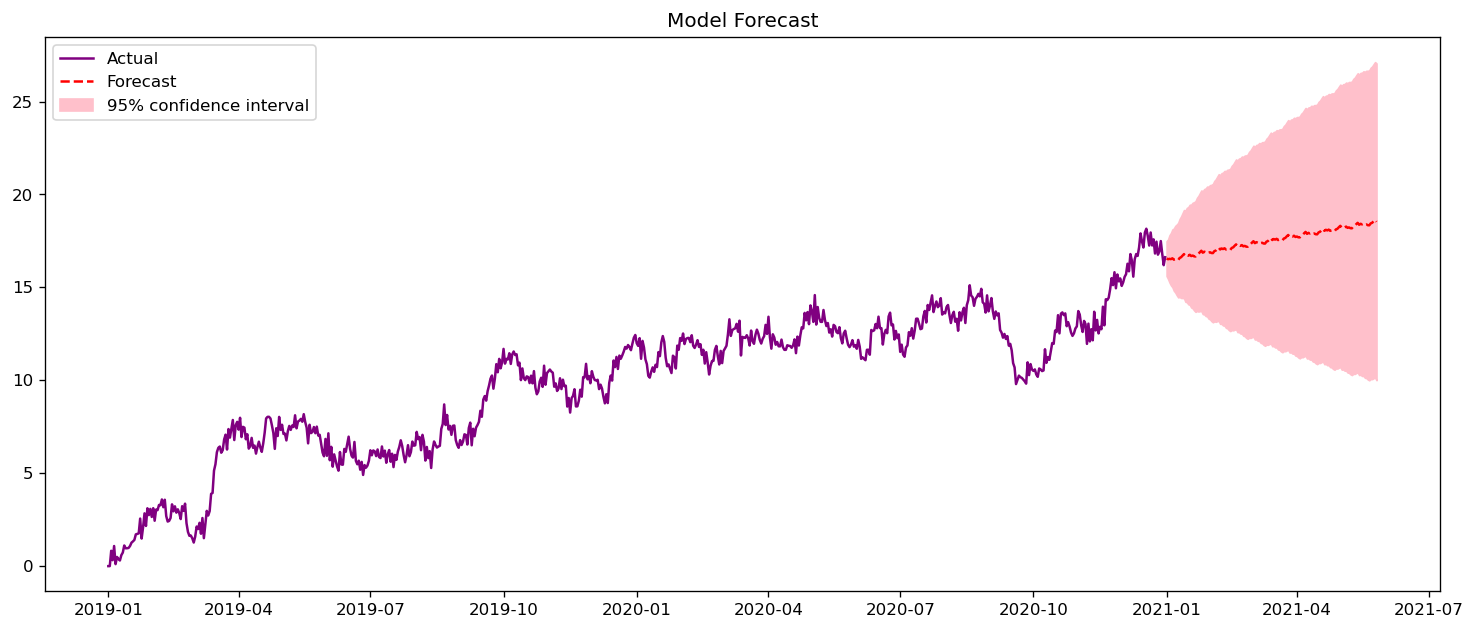

In [53]:
# Plot forecast and confidence intervals

plt.plot(df, color='purple', label='Actual')
plt.plot(forecast_result.predicted_mean, color='red', label='Forecast', linestyle='dashed')
plt.fill_between(confidence_intervals.index, confidence_intervals['lower Revenue'], confidence_intervals['upper Revenue'], color = 'pink', label='95% confidence interval')
plt.plot()
plt.legend(loc='upper left')
plt.title('Model Forecast')
plt.show()

### E3: Recommendation
* Upon observation of our final model, it appears that we have a gradually increasing trend of revenue in future months when focusing on the forecast portion. We are able to predict revenue in the following months with this current finaly model. However, we could argue that our forecast does not align too well with our observed values. One recommendation I can make to possibly assist in creating a better forecasting model would be to create a comparison model using publicly traded competitor data if available and see if the same trends are replicated with that data. Ultimately, I can say that we can use this to forecast revenue, but with caution based on the caveats I have outlined above.

### F: Reporting
* This document encompasses the entirety of my reports for this time series analysis. The entire report was developed in Jupyter notebook and the .pdf and the .ipynb file are attached with this submission

### G: Source for Third-Party Code 
* Bobbitt, Z. (2021, May 25). Augmented dickey-fuller test in Python (with example). Statology. https://www.statology.org/dickey-fuller-test-python/ 
* GeeksforGeeks. (2024, April 5). How to remove non-stationarity in time series forecasting. https://www.geeksforgeeks.org/how-to-remove-non-stationarity-in-time-series-forecasting/ 
* Jones, K. (2025, February 17). Transforming non-stationary time series with differencing. Medium. https://medium.com/@kylejones_47003/transforming-non-stationary-time-series-with-differencing-472d69af53fd 

### H: Sources
* Kuo, A. (2024, June 12). What is time series analysis?. Julius AI. https://julius.ai/articles/what-is-time-series-analysis 
* Nicolini, M. (2025, January 22). Time Series Forecasting: A practical guide to exploratory data analysis. Towards Data Science. https://towardsdatascience.com/time-series-forecasting-a-practical-guide-to-exploratory-data-analysis-a101dc5f85b1/ 
* Resende, D. (2024, January 26). Arima, Sarima, and SARIMAX explained. Zero To Mastery. https://zerotomastery.io/blog/arima-sarima-sarimax-explained/ 